In [102]:
# Stations
# Runs
import os
import pandas as pd
import numpy as np
from stompy import utils
import six
import matplotlib.gridspec as gridspec
from stompy import filters
import matplotlib.pyplot as plt
%matplotlib notebook

from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver

In [45]:
modelA=sun_driver.SuntansModel.load("runs/newgrid20190301-03b/")
modelA.projection="EPSG:26910"


INFO:UnstructuredGrid:Will flip 0 edges


In [16]:
cache_dir="cache"
os.path.exists(cache_dir) or os.makedirs(cache_dir)

True

In [39]:
start=modelA.run_start
end  =modelA.run_stop

def noaa_water_level(station,start,stop,**kw):
    ds=noaa_coops.coops_dataset_product(station=station,product='water_level',
                                        start_date=start,end_date=stop,
                                        cache_dir=cache_dir)
    ds=ds.set_coords(['lon','lat'])
    da=ds.water_level.isel(station=0)
    da.attrs.update(kw)
    return da
alameda_wl=noaa_water_level(9414750,start,end,name="NOAA Alameda")
alameda_wl

INFO:noaa_coops:Cached   2017-07-01 00:00:00 -- 2017-08-01 00:00:00


<xarray.DataArray 'water_level' (time: 7441)>
array([1.576, 1.614, 1.647, ..., 1.443, 1.475, 1.51 ])
Coordinates:
    station  <U7 '9414750'
    lat      float64 37.77
    lon      float64 -122.3
  * time     (time) datetime64[ns] 2017-07-01 2017-07-01T00:06:00 ... 2017-08-01
Attributes:
    datum:    NAVD
    name:     NOAA Alameda

In [96]:
da.name='water_level'
da

<xarray.DataArray 'water_level' (time: 2976)>
array([-3.455683, -3.386142, -3.323038, ..., -3.695609, -3.624858, -3.554767])
Coordinates:
  * time     (time) datetime64[ns] 2017-07-01 ... 2017-07-31T23:45:00

In [97]:
six.moves.reload_module(sun_driver)
modelA=sun_driver.SuntansModel.load("runs/newgrid20190301-03b/")
modelA.projection="EPSG:26910"

#def 
models=[modelA]
observations=[alameda_wl]

# Extract relevant variable and location from model

base_obs=observations[0] # defines the variable and location for extracting model data
model_data=[] # a data array per model
for model in models:
    ds=model.extract_station(ll=[base_obs.lon,base_obs.lat])
    if base_obs.name=='water_level':
        da=ds['eta']
        da.name='water_level' # having the same name helps later
    else:
        raise Exception("Not yet ready")
    model_data.append(da)

# For many plots and metrics need a common timeline -- 
# Get them on common time frames
mod_df=mod.to_dataframe()
obs_df=obs.to_dataframe()

mod_df_com=mod_df.resample('15T').mean()
obs_df_com=obs_df.resample('15T').mean()

# combine to common dataframe
combined=pd.merge(mod_df_com,obs_df_com,left_index=True,right_index=True,suffixes=('_mod','_obs'))


INFO:UnstructuredGrid:Will flip 0 edges


<IPython.core.display.Javascript object>


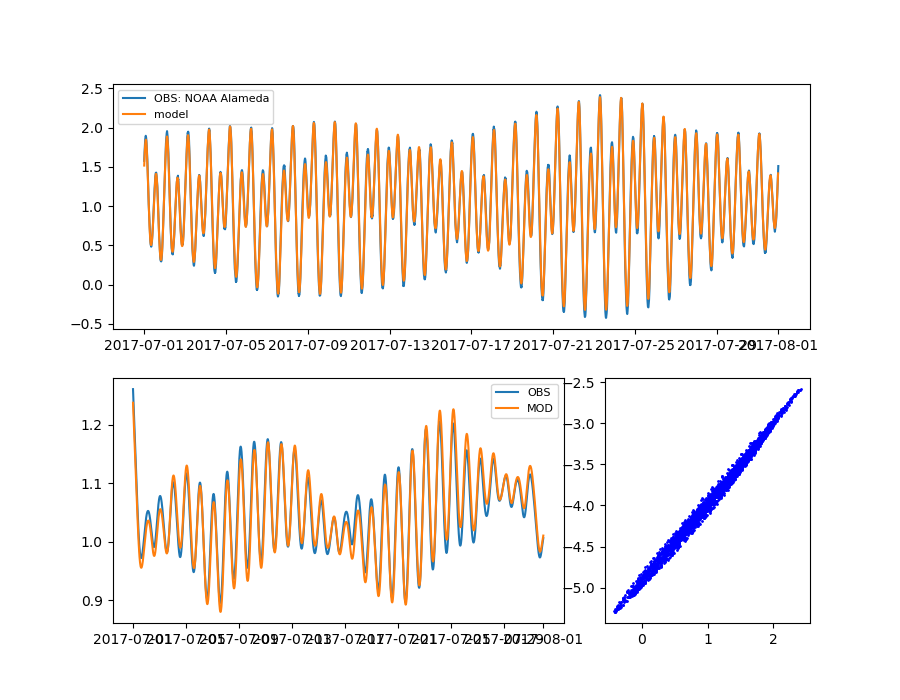

In [104]:
gs = gridspec.GridSpec(2, 3)
fig=plt.figure(figsize=(9,7))
ts_ax = fig.add_subplot(gs[0, :])
lp_ax = fig.add_subplot(gs[1, :-1])
scat_ax=fig.add_subplot(gs[1, -1])

offset_mode='obs' # Adjust means to match observation mean

if offset_mode=='model':
    obs_offset=obs_mean-model_mean
else:
    obs_offset=0.0
if offset_mode=='obs':
    mod_offset=model_mean-obs_mean
else:
    mod_offset=0.0

if 1: # Tidal time scale plot:
    ax=ts_ax
    obs_mean=np.nanmean(observations[0].values)
    model_mean=np.mean(model_data[0].values)

    for obs in observations:
        ax.plot(obs.time,obs.values-obs_offset,label="OBS: %s"%obs.attrs['name'])
    for mod in model_data:
        ax.plot(mod.time,mod.values-mod_offset,label='model')
    ax.legend(fontsize=8)

# Scatter:
if 1:
    ax=scat_ax
    ax.plot(combined.water_level_obs,combined.water_level_mod,'b.',ms=2)
    
# Lowpass:
if 1:
    ax=lp_ax
    t=combined.index.values
    lp_samples=36*4
    ax.plot(t,
            filters.lowpass_fir(combined.water_level_obs,lp_samples)-obs_offset,
            label='OBS')
    ax.plot(t, 
            filters.lowpass_fir(combined.water_level_mod,lp_samples)-mod_offset,
            label='MOD')
    ax.legend(fontsize=8)
    